In [3]:
import os

In [50]:
%pwd

'/Users/birukzewdie/Desktop/Deep_Learning_preoject/Plants_disease_classification_CNN'

In [5]:
os.chdir("../")

In [6]:
%pwd

'/Users/birukzewdie/Desktop/Deep_Learning_preoject/Plants_disease_classification_CNN'

In [90]:
import tensorflow as tf
from keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

IMAGE_SIZE = 224
BATCH_SIZE = 16
CHANNELS = 3
EPOCHS = 10

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "artifacts/data_ingestion/data_plants",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 695 files belonging to 3 classes.


In [91]:
len(dataset)

44

In [92]:
44 * 16

704

In [93]:
class_names = dataset.class_names
class_names

['P_Early_Blight', 'P_Healthy', 'P_Late_Blight']

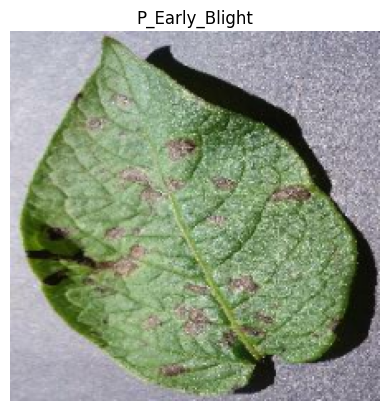

In [94]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")

In [80]:
### 1st Entity
from dataclasses import dataclass
from pathlib import Path


@dataclass(frozen=True)
class TrainingConfig:
    root_dir: Path
    trained_model_path: Path
    updated_base_model_path: Path
    training_data: Path
    params_epochs: int
    params_batch_size: int
    params_is_augmentation: bool
    params_image_size: list



@dataclass(frozen=True)
class PrepareCallbacksConfig:
    root_dir: Path
    tensorboard_root_log_dir: Path
    checkpoint_model_filepath: Path

In [81]:
from src.cnnClassifier.constants import *
from src.cnnClassifier.utils.common import read_yaml, create_directories
import tensorflow as tf

In [95]:
class ConfigurationManager:
    def __init__(
        self, 
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH):
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        create_directories([self.config.artifacts_root])


    
    def get_prepare_callback_config(self) -> PrepareCallbacksConfig:
        config = self.config.prepare_callbacks
        model_ckpt_dir = os.path.dirname(config.checkpoint_model_filepath)
        create_directories([
            Path(model_ckpt_dir),
            Path(config.tensorboard_root_log_dir)
        ])

        prepare_callback_config = PrepareCallbacksConfig(
            root_dir=Path(config.root_dir),
            tensorboard_root_log_dir=Path(config.tensorboard_root_log_dir),
            checkpoint_model_filepath=Path(config.checkpoint_model_filepath)
        )

        return prepare_callback_config
    




    def get_training_config(self) -> TrainingConfig:
        training = self.config.training
        prepare_base_model = self.config.prepare_base_model
        params = self.params
        training_data = os.path.join(self.config.data_ingestion.unzip_dir, "data_plants")
        create_directories([
            Path(training.root_dir)
        ])

        training_config = TrainingConfig(
            root_dir=Path(training.root_dir),
            trained_model_path=Path(training.trained_model_path),
            updated_base_model_path=Path(prepare_base_model.updated_base_model_path),
            training_data=Path(training_data),
            params_epochs=params.EPOCHS,
            params_batch_size=params.BATCH_SIZE,
            params_is_augmentation=params.AUGMENTATION,
            params_image_size=params.IMAGE_SIZE
        )

        return training_config

In [20]:
import time

In [96]:
class PrepareCallback:
    def __init__(self, config: PrepareCallbacksConfig):
        self.config = config


    
    @property
    def _create_tb_callbacks(self):
        timestamp = time.strftime("%Y-%m-%d-%H-%M-%S")
        tb_running_log_dir = os.path.join(
            self.config.tensorboard_root_log_dir,
            f"tb_logs_at_{timestamp}",
        )
        return tf.keras.callbacks.TensorBoard(log_dir=tb_running_log_dir)
    

    @property
    def _create_ckpt_callbacks(self):
        return tf.keras.callbacks.ModelCheckpoint(
            filepath=str(self.config.checkpoint_model_filepath),
            save_best_only=True
        )


    def get_tb_ckpt_callbacks(self):
        return [
            self._create_tb_callbacks,
            self._create_ckpt_callbacks
        ]

In [22]:
import os
import urllib.request as request
from zipfile import ZipFile
import tensorflow as tf
import time

In [97]:
class Training:
    def __init__(self, config: TrainingConfig):
        self.config = config
    
    def get_base_model(self):
        self.model = tf.keras.models.load_model(
            self.config.updated_base_model_path
        )
    
    def train_valid_generator(self):

        datagenerator_kwargs = dict(
            rescale = 1./255,
            validation_split=0.20
        )

        dataflow_kwargs = dict(
            target_size=self.config.params_image_size[:-1],
            batch_size=self.config.params_batch_size,
            interpolation="bilinear"
        )

        valid_datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(
            **datagenerator_kwargs
        )

        self.valid_generator = valid_datagenerator.flow_from_directory(
            directory=self.config.training_data,
            subset="validation",
            shuffle=False,
            **dataflow_kwargs
        )

        if self.config.params_is_augmentation:
            train_datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(
                rotation_range=40,
                horizontal_flip=True,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                **datagenerator_kwargs
            )
        else:
            train_datagenerator = valid_datagenerator

        self.train_generator = train_datagenerator.flow_from_directory(
            directory=self.config.training_data,
            subset="training",
            shuffle=True,
            **dataflow_kwargs
        )

    @staticmethod
    def save_model(path: Path, model: tf.keras.Model):
        model.save(path)


    def train(self, callback_list: list):
        self.steps_per_epoch = self.train_generator.samples // self.train_generator.batch_size
        self.validation_steps = self.valid_generator.samples // self.valid_generator.batch_size

        self.model.fit(
            self.train_generator,
            epochs=self.config.params_epochs,
            steps_per_epoch=self.steps_per_epoch,
            validation_steps=self.validation_steps,
            validation_data=self.valid_generator,
            callbacks=callback_list
        )

        self.model.fit(
            self.train_generator,
            epochs=self.config.params_epochs,
            steps_per_epoch=self.steps_per_epoch,
            validation_steps=self.validation_steps,
            validation_data=self.valid_generator,
            callbacks=callback_list
)

        self.save_model(
            path=self.config.trained_model_path,
            model=self.model
        )

In [99]:
try:
    config = ConfigurationManager()
    prepare_callbacks_config = config.get_prepare_callback_config()
    prepare_callbacks = PrepareCallback(config=prepare_callbacks_config)
    callback_list = prepare_callbacks.get_tb_ckpt_callbacks()

    training_config = config.get_training_config()
    training = Training(config=training_config)
    training.get_base_model()
    training.train_valid_generator()
    training.train(
        callback_list=callback_list
    )
    
except Exception as e:
    raise e

[2024-03-01 16:37:27,612: INFO: common: yaml file: config/config.yaml loaded successfully]
[2024-03-01 16:37:27,615: INFO: common: yaml file: params.yaml loaded successfully]
[2024-03-01 16:37:27,615: INFO: common: created directory at: artifacts]
[2024-03-01 16:37:27,616: INFO: common: created directory at: artifacts/prepare_callbacks/checkpoint_dir]
[2024-03-01 16:37:27,617: INFO: common: created directory at: artifacts/prepare_callbacks/tensorboard_log_dir]
[2024-03-01 16:37:27,618: INFO: common: created directory at: artifacts/training]
Found 137 images belonging to 3 classes.
Found 558 images belonging to 3 classes.
Epoch 1/15


InvalidArgumentError: Graph execution error:

Detected at node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/Users/birukzewdie/Desktop/Deep_Learning_preoject/Plants_disease_classification_CNN/plants_env/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/Users/birukzewdie/Desktop/Deep_Learning_preoject/Plants_disease_classification_CNN/plants_env/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/Users/birukzewdie/Desktop/Deep_Learning_preoject/Plants_disease_classification_CNN/plants_env/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/Users/birukzewdie/Desktop/Deep_Learning_preoject/Plants_disease_classification_CNN/plants_env/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/opt/homebrew/Cellar/python@3.11/3.11.6_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/opt/homebrew/Cellar/python@3.11/3.11.6_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/opt/homebrew/Cellar/python@3.11/3.11.6_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/Users/birukzewdie/Desktop/Deep_Learning_preoject/Plants_disease_classification_CNN/plants_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 542, in dispatch_queue

  File "/Users/birukzewdie/Desktop/Deep_Learning_preoject/Plants_disease_classification_CNN/plants_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 531, in process_one

  File "/Users/birukzewdie/Desktop/Deep_Learning_preoject/Plants_disease_classification_CNN/plants_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/Users/birukzewdie/Desktop/Deep_Learning_preoject/Plants_disease_classification_CNN/plants_env/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 359, in execute_request

  File "/Users/birukzewdie/Desktop/Deep_Learning_preoject/Plants_disease_classification_CNN/plants_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 775, in execute_request

  File "/Users/birukzewdie/Desktop/Deep_Learning_preoject/Plants_disease_classification_CNN/plants_env/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 446, in do_execute

  File "/Users/birukzewdie/Desktop/Deep_Learning_preoject/Plants_disease_classification_CNN/plants_env/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/birukzewdie/Desktop/Deep_Learning_preoject/Plants_disease_classification_CNN/plants_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/Users/birukzewdie/Desktop/Deep_Learning_preoject/Plants_disease_classification_CNN/plants_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/Users/birukzewdie/Desktop/Deep_Learning_preoject/Plants_disease_classification_CNN/plants_env/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/birukzewdie/Desktop/Deep_Learning_preoject/Plants_disease_classification_CNN/plants_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/Users/birukzewdie/Desktop/Deep_Learning_preoject/Plants_disease_classification_CNN/plants_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/Users/birukzewdie/Desktop/Deep_Learning_preoject/Plants_disease_classification_CNN/plants_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/var/folders/h4/4f1dd3392y134gkcvw6sfk1r0000gn/T/ipykernel_77219/4168310261.py", line 11, in <module>

  File "/var/folders/h4/4f1dd3392y134gkcvw6sfk1r0000gn/T/ipykernel_77219/3337820644.py", line 63, in train

  File "/Users/birukzewdie/Desktop/Deep_Learning_preoject/Plants_disease_classification_CNN/plants_env/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/birukzewdie/Desktop/Deep_Learning_preoject/Plants_disease_classification_CNN/plants_env/lib/python3.11/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/Users/birukzewdie/Desktop/Deep_Learning_preoject/Plants_disease_classification_CNN/plants_env/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/Users/birukzewdie/Desktop/Deep_Learning_preoject/Plants_disease_classification_CNN/plants_env/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/Users/birukzewdie/Desktop/Deep_Learning_preoject/Plants_disease_classification_CNN/plants_env/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/Users/birukzewdie/Desktop/Deep_Learning_preoject/Plants_disease_classification_CNN/plants_env/lib/python3.11/site-packages/keras/src/engine/training.py", line 1151, in train_step

  File "/Users/birukzewdie/Desktop/Deep_Learning_preoject/Plants_disease_classification_CNN/plants_env/lib/python3.11/site-packages/keras/src/engine/training.py", line 1209, in compute_loss

  File "/Users/birukzewdie/Desktop/Deep_Learning_preoject/Plants_disease_classification_CNN/plants_env/lib/python3.11/site-packages/keras/src/engine/compile_utils.py", line 277, in __call__

  File "/Users/birukzewdie/Desktop/Deep_Learning_preoject/Plants_disease_classification_CNN/plants_env/lib/python3.11/site-packages/keras/src/losses.py", line 143, in __call__

  File "/Users/birukzewdie/Desktop/Deep_Learning_preoject/Plants_disease_classification_CNN/plants_env/lib/python3.11/site-packages/keras/src/losses.py", line 270, in call

  File "/Users/birukzewdie/Desktop/Deep_Learning_preoject/Plants_disease_classification_CNN/plants_env/lib/python3.11/site-packages/keras/src/losses.py", line 2454, in sparse_categorical_crossentropy

  File "/Users/birukzewdie/Desktop/Deep_Learning_preoject/Plants_disease_classification_CNN/plants_env/lib/python3.11/site-packages/keras/src/backend.py", line 5775, in sparse_categorical_crossentropy

logits and labels must have the same first dimension, got logits shape [5,3] and labels shape [15]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_18702]